In [7]:
import pandas as pd
import numpy as np
import re

from viewer.utils import create_df_from_run_data
from viewer.agg_score_metrics import agg_score_metrics
from viewer.results import fetch_run_list, fetch_run_results, render_results_table

def load_data(results_uri, run_regex):
    runs = [x for x in fetch_run_list(results_uri)[0]]
    runs = [x for x in runs if re.search(run_regex, x)]


    results    = fetch_run_results(results_uri, runs, "%500")[0]
    # Filter results with following regex
    df = create_df_from_run_data(results)


    return df
results_uri = "s3://fineweb-multilingual-v1/evals/results/"
run_regex = f"1p46G-gemma-(commoncrawl|defi-rehydrfix|hplt|mc4|cultura|cc-100).*-29BT-.*"
df = load_data(results_uri, run_regex)



Loading evals data...: 100%|██████████| 2407/2407 [00:05<00:00, 468.20it/s]


In [11]:
import os
from viewer.agg_score_metrics import agg_score_metrics
from viewer.results import render_results_table
considered_langs = ['ar', 'fr', 'ru', 'th', 'tr', 'zh']
# considered_langs = agg_score_metrics["acc"].keys()
lang_dfs = {}
eval_type = "prob"
norm_method = "Z-norm"
# for lang in considered_langs:
os.makedirs("data/results", exist_ok=True)
for lang in considered_langs:
    if lang == "all":
        continue
    selected_cols = agg_score_metrics[eval_type][lang]
    runname_seed = df["runname"] + "-seed-" + df["seed"].astype(str)
    normalization_runs = set(runname_seed)
    normalization_runs = [x for x in normalization_runs if re.search(f"1p46G-gemma-(commoncrawl|hplt-|mc4|cultura|cc-100).*{lang}-29BT-.*", x)]

    # Only select the rows where runname contains -lang-
    lang_df = df[df["runname"].str.contains(f"-{lang}-")].copy()
    # Now take only those that contain 
    new_df, _, _ = render_results_table(lang_df, metrics=["agg_score_metrics"], task_avg="show_averages", normalization_runs=list(normalization_runs), baseline_runs=[], baseline_mode="Mean", clip_scores=False, normalization_mode=norm_method, aggregate_score_cols=selected_cols, language=lang, variability_window=5, mcq_type=eval_type)
    lang_dfs[lang] = new_df

/Users/hynky/Projects/Fineweb-Multilingual/fineweb-2/graphs/viewer/results.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{task}:_average|{metric}"] = df[cols].mean(axis=1)
/Users/hynky/Projects/Fineweb-Multilingual/fineweb-2/graphs/viewer/results.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{task}:_average|{metric}"] = df[cols].mean(axis=1)
/Users/hynky/Projects/Fineweb-Multilingual/fineweb-2/graphs/viewer/results.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

## Line plot with normal averaging

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/834156765.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"].rolling(window=1, min_periods=1).mean() - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/834156765.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"].rolling(window=1, min_periods=1).mean() - min_step_0


KeyError: '1p46G-gemma-defi-rehydrto-29BT'

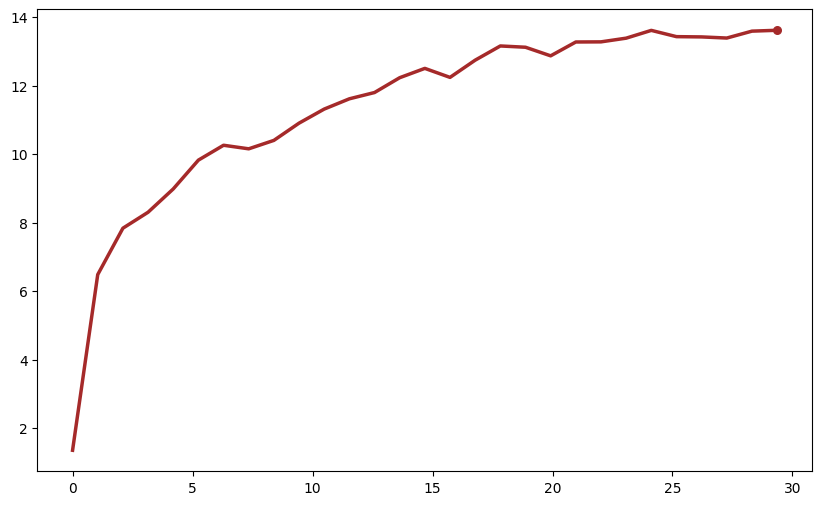

In [12]:
# Simplify each language DataFrame and merge them
def prepare_lang_df(lang_df, lang):
    lang_df = lang_df.groupby(["runname", "steps"]).agg({"agg_score_macro": "mean"}).reset_index()

    # Keep only required columns
    simple_df = lang_df[['runname', 'steps', 'agg_score_macro']].copy()
    
    # Remove language tag from runname
    simple_df['runname'] = simple_df['runname'].str.replace(f'-{lang}-', '-', regex=False)
    
    # Rename agg_score_macro to include language for merging
    simple_df = simple_df.rename(columns={'agg_score_macro': f'agg_score'})
    return simple_df

simplified_dfs = []
for lang, lang_df in lang_dfs.items():
    # First group by seeds
    simplified_dfs.append(prepare_lang_df(lang_df, lang))

# Merge all simplified DataFrames
merged_df = simplified_dfs[0]
for single_df in simplified_dfs[1:]:
    merged_df = pd.merge(merged_df, single_df, on=['runname', 'steps'], how='outer', suffixes=('', f'_{lang}'))

# Calculate average across all languages
score_columns = [col for col in merged_df.columns if col.startswith('agg_score')]
merged_df['average_score'] = merged_df[score_columns].mean(axis=1)

# Create the plot using matplotlib
from collections import OrderedDict
import matplotlib.pyplot as plt
import re

rename_patterns = {
    r'1p46G-gemma-cc-100-29BT': 'CC-100',
    r'1p46G-gemma-commoncrawl-29BT': 'CommonCrawl',
    r'1p46G-gemma-culturax-29BT': 'CulturaX',
    r'1p46G-gemma-defi-rehydrfix-29BT': 'FineWeb 2 (Ours)',
    r'1p46G-gemma-hplt-29BT': 'HPLT',
    r'1p46G-gemma-arabicweb24-29BT': 'ArabicWeb',
    r'1p46G-gemma-101b_arabicwords-29BT': 'Arabic-101B',
    r'1p46G-gemma-hplt2-29BT': 'HPLT-2',
    r'1p46G-gemma-mc4-29BT': 'mC4',
    r'1p46G-gemma-croissant-29BT': 'Croissant',
    r'1p46G-gemma-omnica_russia-29BT': 'Omnica Russia',
    r'1p46G-gemma-sea-commoncrawl-29BT': 'Sea CommonCrawl',
    r'1p46G-gemma-tigerbot-29BT': 'TigerBot',
    r'1p46G-gemma-mnbvc-29BT': 'MNBVC',
    r'1p46G-gemma-vngrs_web_corpus-29BT': 'VNGRS-Web-Corpus',
    r'1p46G-gemma-odaigen_hindi-29BT': 'Odaigen',
    r'1p46G-gemma-sangraha-29BT': 'Sangraha'
}
color_map = {
    'FineWeb 2 (Ours)': 'black',
    'CulturaX': '#1f77b4',
    'HPLT-2': 'orange',
    'CC-100': '#2ca02c',
    'mC4': 'red',
    'HPLT': 'mediumpurple',
    'CommonCrawl': 'gray',
    # Mono
    'Croissant': 'brown',
    'TigerBot': 'brown',
    'VNGRS-Web-Corpus': 'brown',
    'Sea CommonCrawl': 'brown',
    'ArabicWeb': 'brown',
    'Omnica Russia': 'brown',
    'Sangraha': 'brown',
    'Arabic-101B': 'pink',
    'Odaigen': 'pink',
    'MNBVC': 'pink',
}

for pattern, replacement in rename_patterns.items():
    merged_df['runname'] = merged_df['runname'].str.replace(pattern, replacement, regex=False)

unique_runs = merged_df['runname'].unique()
# Create figure
plt.figure(figsize=(10, 6))

# Sort unique_runs based on the value at step 14000
sorted_runs = merged_df[merged_df['steps'] == 14000].sort_values(by='average_score', ascending=False)['runname']

tableau_colors = ['black', '#1f77b4', 'orange', '#2ca02c', 'red', 'mediumpurple', 'gray']

merged_df = merged_df.sort_values(by='steps')
min_step_0 = merged_df[merged_df['steps'] == 0]['average_score'].min()
for i, run in enumerate(sorted_runs):
    run_data = merged_df[merged_df['runname'] == run]
    # Use rolling mean with window 3
    run_data["average_score"] = run_data["average_score"].rolling(window=1, min_periods=1).mean() - min_step_0
    plt.plot(run_data['steps'] * 2048 * 1024 * 1e-9, run_data['average_score'], label=run, color=color_map[run], linewidth=2.5)
    plt.scatter(run_data['steps'].iloc[-1] * 2048 * 1024 * 1e-9, run_data['average_score'].iloc[-1], color=color_map[run], s=30)

# Update layout
plt.title(f"Comparison of Multilingual Datasets on {', '.join([x for x in considered_langs])}")
plt.xlabel('Training tokens (billions)')
plt.ylabel('Average Normalized Score')
plt.ylim(bottom=1.5)  # Set y-axis to start at 0
plt.xlim(left=0)
plt.legend(loc='lower right')  # Position legend to bottom right corner
plt.grid(axis='y', linestyle='--')  # Enable grid only for vertical lines with dashed lines
plt.grid(axis='x', linestyle='--')  # Enable grid only for vertical lines with dashed lines
plt.rcParams['font.family'] = 'Inter'
# Make the font size smaller
plt.rcParams['font.size'] = 12
# plt.show()
# Save figure
import os
os.makedirs("output/graphs", exist_ok=True)
plt.savefig("output/graphs/multilingual_datasets_comparison.png", dpi=300, bbox_inches='tight')


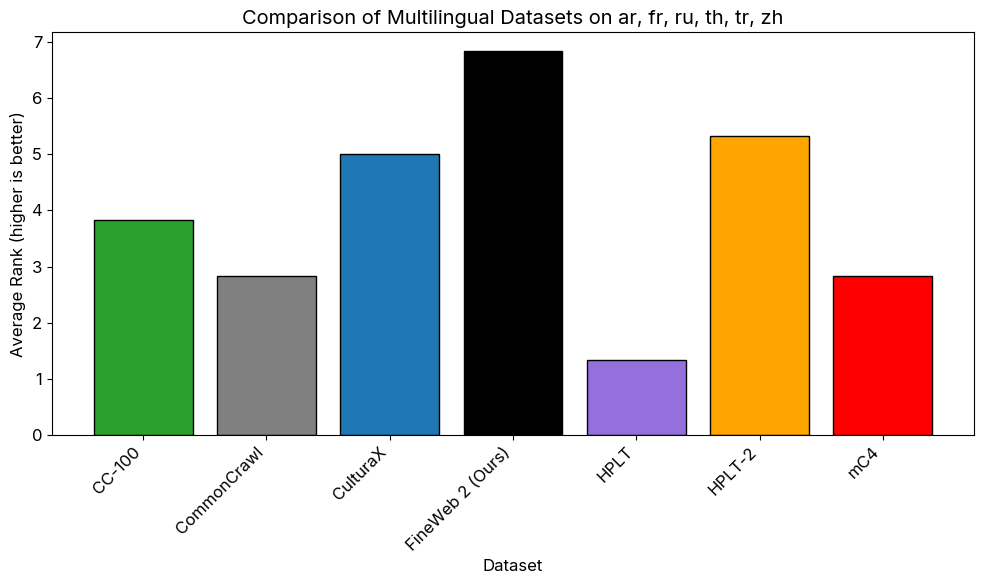

<Figure size 640x480 with 0 Axes>

In [21]:
# Simplify each language DataFrame and merge them
simplified_dfs = []
for lang, lang_df in lang_dfs.items():
    # First group by seeds
    lang_df = lang_df.groupby(["runname", "steps"]).agg({"agg_score_macro": "mean"}).reset_index()
    # Keep only required columns
    simple_df = lang_df[['runname', 'steps', 'agg_score_macro']].copy()
    
    # Compute ranks for each language separately (highest score gets highest rank)
    simple_df['rank'] = simple_df.groupby('steps')['agg_score_macro'].rank(method='min', ascending=True)
    
    # Drop the agg_score_macro column as we don't need it anymore
    simple_df = simple_df.drop('agg_score_macro', axis=1)
    
    # Remove language tag from runname
    for language in lang_dfs.keys():
        simple_df['runname'] = simple_df['runname'].str.replace(f'-{language}-', '-', regex=False)
    
    # Rename rank column to include language for merging
    simple_df = simple_df.rename(columns={'rank': f'rank_{lang}'})
    simplified_dfs.append(simple_df)

# Rest of the code remains the same...
merged_df = simplified_dfs[0]
for lang_df in simplified_dfs[1:]:
    merged_df = pd.merge(merged_df, lang_df, on=['runname', 'steps'], how='outer')

# Calculate average rank across all languages
rank_columns = [col for col in merged_df.columns if col.startswith('rank_')]
merged_df['average_rank'] = merged_df[rank_columns].mean(axis=1)
for pattern, replacement in rename_patterns.items():
    merged_df['runname'] = merged_df['runname'].str.replace(pattern, replacement, regex=False)

# Create the bar plot for step 14000 using matplotlib
step_14000_data = merged_df[merged_df['steps'] == 14000]

plt.figure(figsize=(10, 6))

colors = [color_map.get(run, 'gray') for run in step_14000_data['runname']]
plt.bar(step_14000_data['runname'], step_14000_data['average_rank'], color=colors, edgecolor='black')  # Added edgecolor for outline
plt.title(f"Comparison of Multilingual Datasets on {', '.join([x for x in considered_langs])}")
plt.xlabel('Dataset')
plt.ylabel('Average Rank (higher is better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Save figure
plt.savefig("output/graphs/comparison_rank.png", dpi=300, bbox_inches='tight')

k# All runs

In [8]:

ALL_RUNS_REGEX = "(1p46G-gemma-(commoncrawl|defi-rehydrfix|hplt|mc4|cultura|cc-100|arabicweb|101b_arabic|croissant|omnica|odaigen|sangr|sea-common|vngrs|mapcc|tigerbot|mnbvc).*-29BT-.*)|(1p46G-gemma-defi-rehydrto-sw-29BT-seed-6)"
df = load_data(results_uri, ALL_RUNS_REGEX)


Fetching datafiles...:   0%|          | 0/96 [00:00<?, ?it/s]

Loading evals data...: 100%|██████████| 2784/2784 [00:05<00:00, 509.66it/s]


In [9]:
import os
from viewer.agg_score_metrics import agg_score_metrics
from viewer.results import render_results_table
considered_langs = ['ar', 'fr', 'ru', 'th', 'tr', 'zh', 'te', 'hi', 'sw']
# considered_langs = agg_score_metrics["acc"].keys()
lang_dfs = {}
eval_type = "prob"
norm_method = "Z-norm"
os.makedirs("output/data", exist_ok=True)
# First run with z-nrom then without, only save lang_dfs for z-norm
for lang in considered_langs:
    if lang == "all":
        continue
    selected_cols = agg_score_metrics[eval_type][lang]
    runname_seed = df["runname"] + "-seed-" + df["seed"].astype(str)
    normalization_runs = set(runname_seed)
    normalization_runs = [x for x in normalization_runs if re.search(f"1p46G-gemma-(commoncrawl|hplt-|mc4|cultura|cc-100).*{lang}-29BT-.*", x)]

    # Only select the rows where runname contains -lang-
    lang_df = df[df["runname"].str.contains(f"-{lang}-")].copy()
    # Now take only those that contain 
    new_df, _, _ = render_results_table(lang_df, metrics=["agg_score_metrics"], task_avg="show_averages", normalization_runs=list(normalization_runs), baseline_runs=[], baseline_mode="Mean", clip_scores=False, normalization_mode=norm_method, aggregate_score_cols=selected_cols, language=lang, variability_window=5, mcq_type=eval_type)
    new_df.to_csv(f"output/data/eval_score_{lang}_norm.csv")
    lang_dfs[lang] = new_df


# Then run without z-norm
for lang in considered_langs:
    if lang == "all":
        continue
    selected_cols = agg_score_metrics[eval_type][lang]
    # Only select the rows where runname contains -lang-
    lang_df = df[df["runname"].str.contains(f"-{lang}-")].copy()
    # Now take only those that contain 
    new_df, _, _ = render_results_table(lang_df, metrics=["agg_score_metrics"], task_avg="show_averages", normalization_runs=[], baseline_runs=[], baseline_mode="Mean", clip_scores=False, normalization_mode="No adjustment", aggregate_score_cols=selected_cols, language=lang, variability_window=5, mcq_type=eval_type)
    new_df.to_csv(f"output/data/eval_score_{lang}.csv")

/Users/hynky/Projects/Fineweb-Multilingual/fineweb-2/admin/viewer/results.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{task}:_average|{metric}"] = df[cols].mean(axis=1)
/Users/hynky/Projects/Fineweb-Multilingual/fineweb-2/admin/viewer/results.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{task}:_average|{metric}"] = df[cols].mean(axis=1)
/Users/hynky/Projects/Fineweb-Multilingual/fineweb-2/admin/viewer/results.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

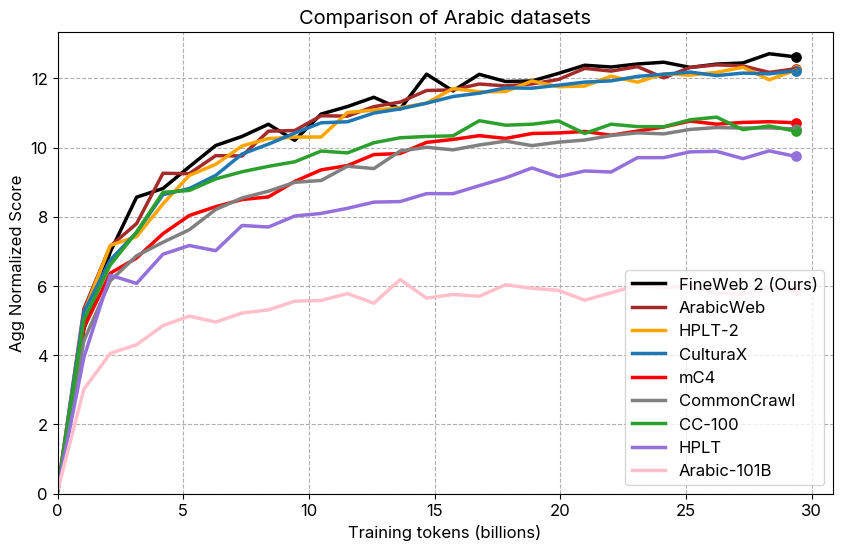

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

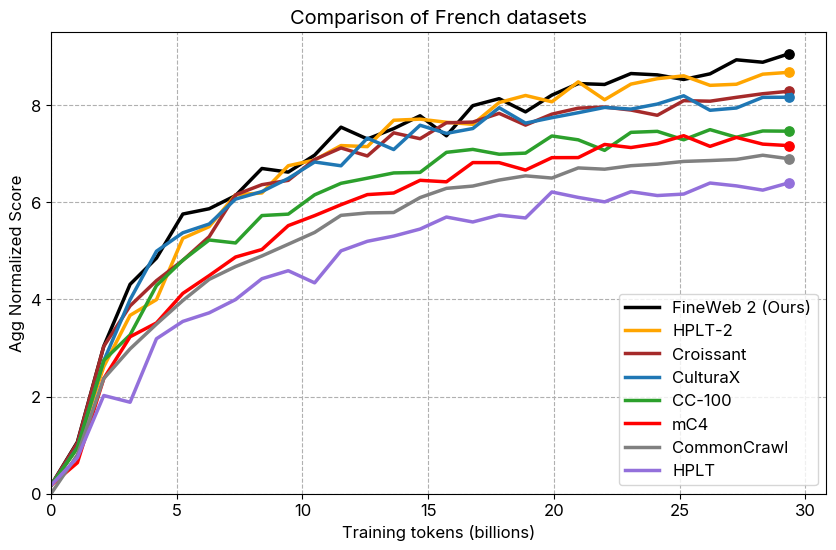

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

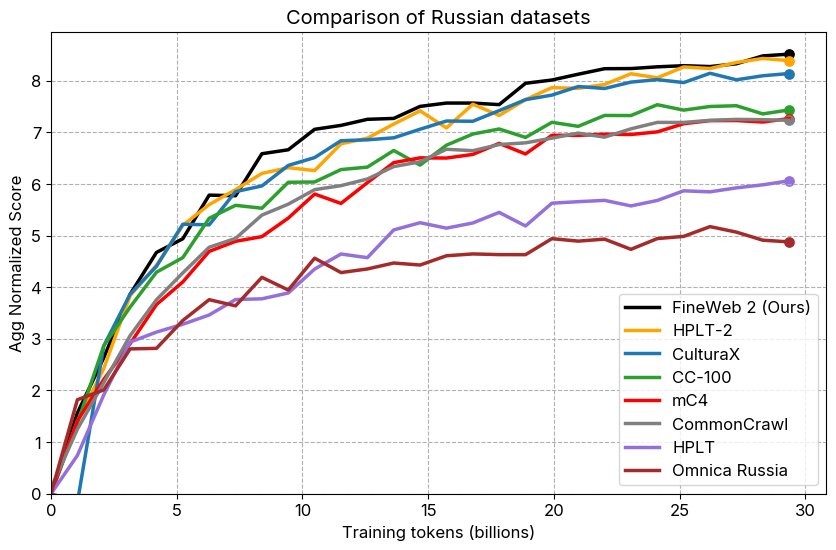

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

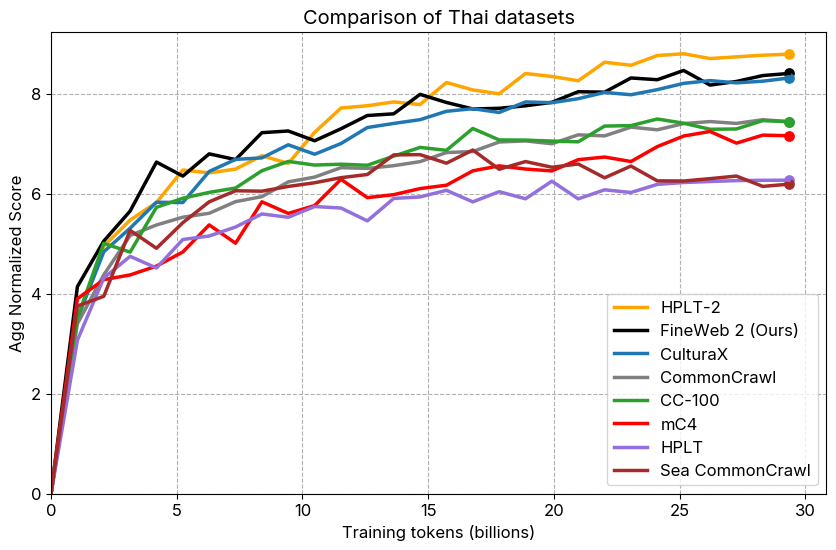

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

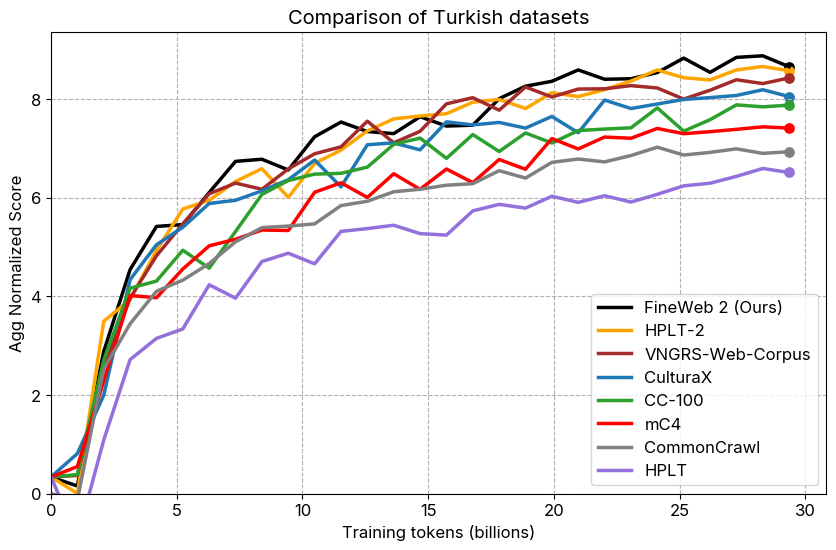

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

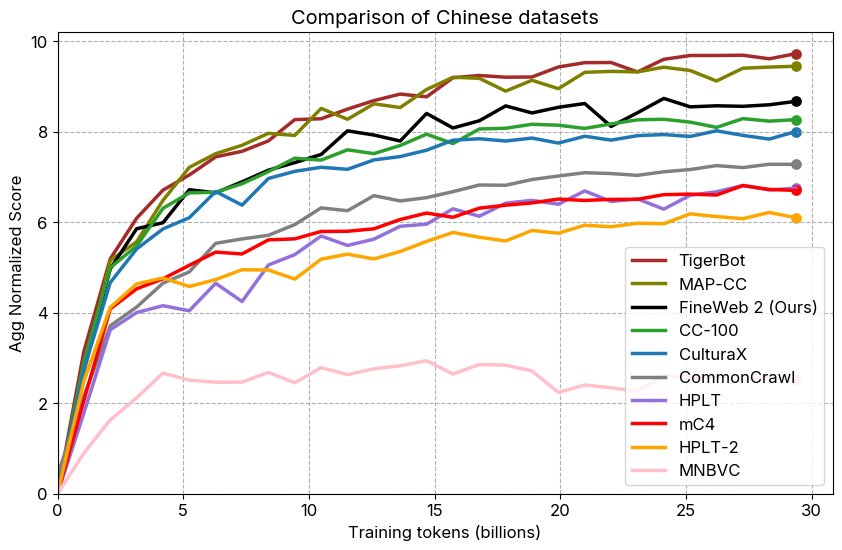

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

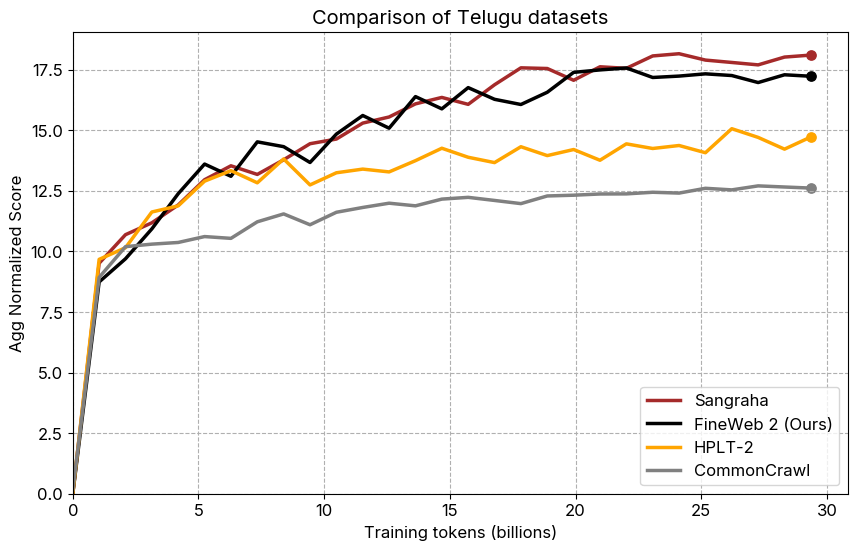

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

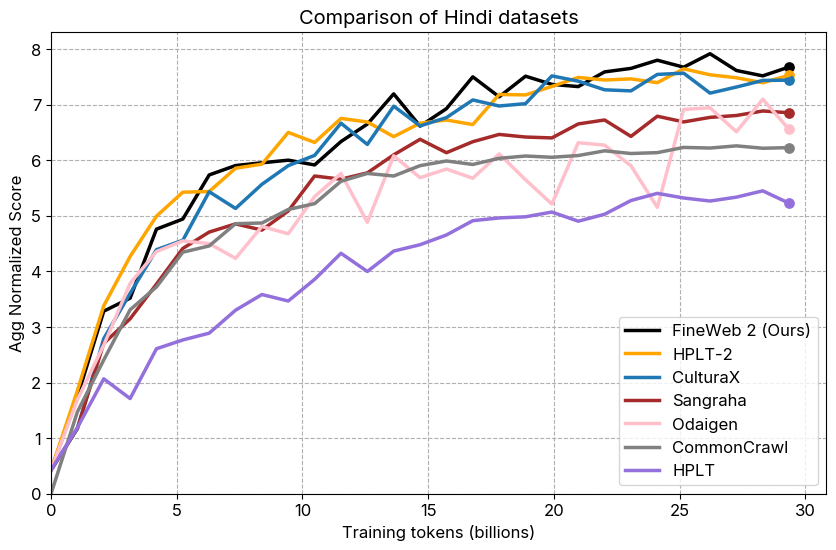

/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data["average_score"] = run_data["average_score"] - min_step_0
/var/folders/ry/w953ycvs06bd2crg_z94yff00000gn/T/ipykernel_17396/3305197633.py:82: SettingWithCopyWarning: 
A value is t

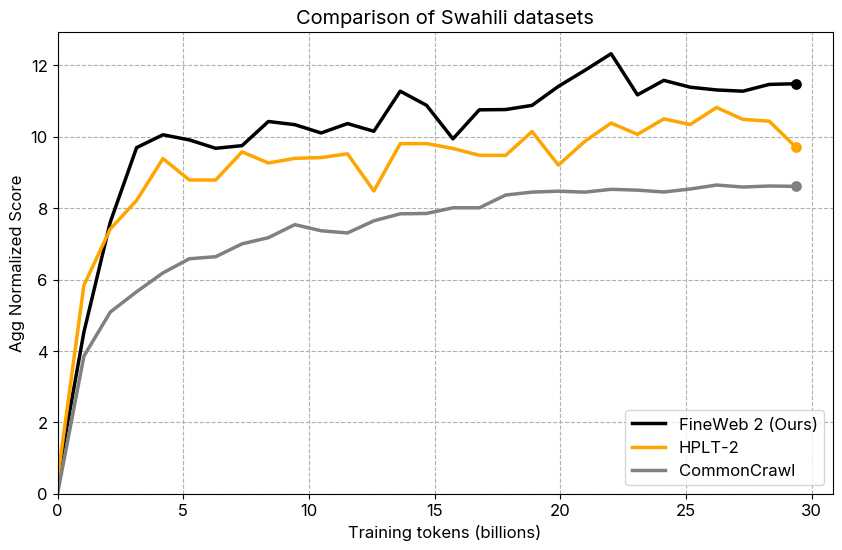

In [14]:
# Create the plot using matplotlib
from collections import OrderedDict
import matplotlib.pyplot as plt

# Get unique runnames

# Rename runnames using regex
rename_patterns = {
    r'1p46G-gemma-cc-100-29BT': 'CC-100',
    r'1p46G-gemma-commoncrawl-29BT': 'CommonCrawl',
    r'1p46G-gemma-culturax-29BT': 'CulturaX',
    r'1p46G-gemma-defi-rehydrfix-29BT': 'FineWeb 2 (Ours)',
    r'1p46G-gemma-defi-rehydrto-29BT': 'FineWeb 2 (Ours)',
    r'1p46G-gemma-hplt-29BT': 'HPLT',
    r'1p46G-gemma-arabicweb24-29BT': 'ArabicWeb',
    r'1p46G-gemma-101b_arabicwords-29BT': 'Arabic-101B',
    r'1p46G-gemma-hplt2-29BT': 'HPLT-2',
    r'1p46G-gemma-mc4-29BT': 'mC4',
    r'1p46G-gemma-croissant-29BT': 'Croissant',
    r'1p46G-gemma-omnica_russia-29BT': 'Omnica Russia',
    r'1p46G-gemma-sea-commoncrawl-29BT': 'Sea CommonCrawl',
    r'1p46G-gemma-tigerbot-29BT': 'TigerBot',
    r'1p46G-gemma-mnbvc-29BT': 'MNBVC',
    r'1p46G-gemma-vngrs_web_corpus-29BT': 'VNGRS-Web-Corpus',
    r'1p46G-gemma-odaigen_hindi-29BT': 'Odaigen',
    r'1p46G-gemma-sangraha-29BT': 'Sangraha',
    r'1p46G-gemma-mapcc-1-10-29BT': 'MAP-CC'
}
color_map = {
    'FineWeb 2 (Ours)': 'black',
    'CulturaX': '#1f77b4',
    'HPLT-2': 'orange',
    'CC-100': '#2ca02c',
    'mC4': 'red',
    'HPLT': 'mediumpurple',
    'CommonCrawl': 'gray',
    # Mono
    'Croissant': 'brown',
    'TigerBot': 'brown',
    'VNGRS-Web-Corpus': 'brown',
    'Sea CommonCrawl': 'brown',
    'ArabicWeb': 'brown',
    'Omnica Russia': 'brown',
    'Sangraha': 'brown',
    'Arabic-101B': 'pink',
    'Odaigen': 'pink',
    'MNBVC': 'pink',
    'MAP-CC': 'olive'
}

lang_full_names = {
    'ar': 'Arabic',
    'fr': 'French',
    'ru': 'Russian',
    'th': 'Thai',
    'tr': 'Turkish',
    'zh': 'Chinese',
    'te': 'Telugu',
    'hi': 'Hindi',
    'sw': 'Swahili'
}

# for lang in considered_langs:
for lang in considered_langs:
    merged_df = prepare_lang_df(lang_dfs[lang].copy(), lang)
    merged_df = merged_df.rename(columns={'agg_score': 'average_score'})
    # Rename runnames
    for pattern, replacement in rename_patterns.items():
        merged_df['runname'] = merged_df['runname'].str.replace(pattern, replacement, regex=False)
    unique_runs = merged_df['runname'].unique()
    # Create figure
    plt.figure(figsize=(10, 6))

    # Sort unique_runs based on the value at step 14000
    sorted_runs = merged_df[merged_df['steps'] == 14000].sort_values(by='average_score', ascending=False)['runname']

    merged_df = merged_df.sort_values(by='steps')
    min_step_0 = merged_df[merged_df['steps'] == 0]['average_score'].min()
    for i, run in enumerate(sorted_runs):
        run_data = merged_df[merged_df['runname'] == run]
        # Use rolling mean with window 3
        run_data["average_score"] = run_data["average_score"] - min_step_0
        plt.plot(run_data['steps'] * 2048 * 1024 * 1e-9, run_data['average_score'], label=run, color=color_map[run], linewidth=2.5)
        plt.scatter(run_data['steps'].iloc[-1] * 2048 * 1024 * 1e-9, run_data['average_score'].iloc[-1], color=color_map[run], s=45)

    # Update layout
    plt.title(f"Comparison of {lang_full_names[lang]} datasets")
    plt.xlabel('Training tokens (billions)')
    plt.ylabel('Agg Normalized Score')
    # plt.ylim(bottom=1.5)  # Set y-axis to start at 0
    plt.xlim(left=0)
    plt.legend(loc='lower right')  # Position legend to bottom right corner
    plt.grid(axis='y', linestyle='--')  # Enable grid only for vertical lines with dashed lines
    plt.grid(axis='x', linestyle='--')  # Enable grid only for vertical lines with dashed lines
    plt.rcParams['font.family'] = 'Inter'
    # Make the font size smaller
    plt.rcParams['font.size'] = 12
    # limit y to 0
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    # export
    plt.savefig(f"output/graphs/comparison_{lang}.png", dpi=300, bbox_inches='tight')
    plt.show()
